In [1]:
import pybdsim
import pyg4ometry.geant4 as g4
from pyg4ometry import gdml
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

Warning in <TFile::Init>: no StreamerInfo found in /opt/anaconda3/envs/RFT_bdsim/lib/BDSBH4DBaseDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with ROOT version 6.30/02, while the current version is 6.34.04
Warning in <TFile::Init>: no StreamerInfo found in /opt/anaconda3/envs/RFT_bdsim/lib/BDSBH4DDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with ROOT version 6.30/02, while the current version is 6.34.04
Warning in <TFile::Init>: no StreamerInfo found in /opt/anaconda3/envs/RFT_bdsim/lib/BDSOutputROOTEventApertureDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with ROOT version 6.30/02, while the current version is 6.34.04
Warning in <TFile::Init>: no StreamerInfo found in /opt/anaconda3/envs/RFT_bdsim/lib/BDSOutputROOTEventBeamDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with R

In [43]:
b = pybdsim.Beam.Beam()
b.SetEnergy(200,'MeV')
b.SetDistributionType('gauss')
b.SetParticleType('e-')
b.SetSigmaX(1,'mm')
b.SetSigmaY(1,'mm')
b.SetSigmaXP(1,'mrad')
b.SetSigmaYP(1,'mrad')
b.SetSigmaE(0.005)

machine = pybdsim.Builder.Machine()
machine.AddBeam(b)

In [44]:
#add options
o = pybdsim.Options.Options()
o.SetPhysicsList('em')

machine.AddOptions(o)

In [33]:

def add_s2(machine, max_thickness, radius, N_slices, material):
    s2_sigma = radius / 2
    step = radius / (N_slices)
    x = np.arange(-(radius + step), 0, step=step)
    y = norm.pdf(x, 0, s2_sigma)
    y = y - min(y)
    y_scaling_factor = max_thickness / max(y)
    y = y * y_scaling_factor



    for i in range(1, len(y)):
        L = y[i] - y[i - 1]
        sname = "slice" + str(i)
    
        if L < 0:
            machine.AddTarget(name=sname, length=L/1000, material="Vacuum", horizontalWidth=abs(x[i]) * 2/1000, apertureType="circular")
        else:
            machine.AddTarget(name=sname, length=L/1000, material=material, horizontalWidth=abs(x[i]) * 2/1000, apertureType="circular")
    
    


In [34]:
def add_s2_smooth(machine, max_thickness, rmax, N_slices, material, gdml_name):
    reg  = g4.Registry()
    sigma = rmax/2
    

    step = rmax / N_slices


    # Sample radii and compute radii
    radii = np.arange(0, (rmax+step), step=step)/1000
    z = norm.pdf(radii, 0, sigma )/1000
    z = z - min(z)
    z_scaling_factor = max_thickness / max(z)
    z = z * z_scaling_factor
    # sort by increasing z
    z, radii = zip(*sorted(zip(z, radii)))
    
    solid = g4.solid.Polycone("S2", 0.0, 2*np.pi,
                              list(z),
                              [0.0]*len(z),
                              list(radii),
                              reg)
    
    # World
    world_s = g4.solid.Box("S2_world_s", 100, 100, 100, reg)
    world_l = g4.LogicalVolume(world_s, g4.MaterialPredefined("G4_AIR", reg), "S2_world", reg)

    gauss_l = g4.LogicalVolume(solid, g4.MaterialPredefined("G4_Al", reg), "gauss", reg)
    g4.PhysicalVolume([0,0,0], [0,0,0], gauss_l, "gauss_pv", world_l, reg)
    reg.setWorld(world_l)

    w = gdml.Writer()
    w.addDetector(reg)
    w.write(gdml_name)

    machine.AddElement(name='S2', length=max_thickness/1000, geometryFile='gdml:'+gdml_name)

In [45]:
# adding quads and scatterer
k1s = [8.23470106, -5.77519295, 12.30291714, -70.89257372]

for i in range(len(k1s)):
    machine.AddQuadrupole(f'Q{i+1}', k1=k1s[i],length=0.3)
    machine.AddDrift(f'D{i+1}', length=0.2)
    
#drift after quads (RFT components)
machine.AddDrift(f'D{i+2}',length=0.1) #s2 at 0.1m after RFT
add_s2(machine, 3, 13, 100,"G4_Al")  
#add_s2_smooth(machine, 3,13,100,"G4_Al","s2_geometry.gdml")

machine.AddDrift(f'D{i+3}',length=2.5-0.1-3/1000)
machine.AddTarget(name='watertank', length=0.5, material="G4_WATER", xsize=0, ysize=0,xsizeOut=0.3, ysizeOut=0.3, colour="blue")
dose_depth = 0.01
machine.AddScorer('dose', type="depositeddose")
machine.AddScorer('eDep', type="depositedenergy")
machine.AddScorerMesh('dose_scorer',scoreQuantity="eDep dose", referenceElement="watertank", geometryType="box", 
                      nx=100,ny=100,nz=1, xsize=0.3, ysize=0.3, zsize=dose_depth, z=dose_depth)


In [46]:
machine.Write('lattice_py.gmad')

Lattice written to:
lattice_py_components.gmad
lattice_py_sequence.gmad
lattice_py_beam.gmad
lattice_py_options.gmad
lattice_py_objects.gmad
All included in main file: 
 lattice_py.gmad


In [47]:
pybdsim.Run.Bdsim('lattice_py.gmad', 'testrun', ngenerate=100000)

0

Executable option> inputFileName              : lattice_py.gmad
Executable option> outputFileName             : testrun        
Executable option> ngenerate                  : 100000         
Executable option> batch                      : true           
Executable option> bdsimPath                  : /Users/sabrinawang/Desktop/DPhil_Project/
Executable option> distrFileMatchLength       : false          
BDSIM : version 1.7.7
        (C) 2001-2025 Royal Holloway University London - GPLv3

        Reference: Computer Physics Communications, 107200 (2020)
                   https://doi.org/10.1016/j.cpc.2020.107200
                   https://arxiv.org/abs/1808.10745
        Website:   http://www.pp.rhul.ac.uk/bdsim

parser> reading file /Users/sabrinawang/Desktop/DPhil_Project/lattice_py_components.gmad
parser> reading file /Users/sabrinawang/Desktop/DPhil_Project/lattice_py_sequence.gmad
parser> reading file /Users/sabrinawang/Desktop/DPhil_Project/lattice_py_beam.gmad
parser> reading

python(83234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Warning in <TFile::Init>: no StreamerInfo found in /opt/anaconda3/envs/RFT_bdsim/lib/BDSBH4DBaseDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with ROOT version 6.30/02, while the current version is 6.34.04
Warning in <TFile::Init>: no StreamerInfo found in /opt/anaconda3/envs/RFT_bdsim/lib/BDSBH4DDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with ROOT version 6.30/02, while the current version is 6.34.04
Warning in <TFile::Init>: no StreamerInfo found in /opt/anaconda3/envs/RFT_bdsim/lib/BDSOutputROOTEventApertureDict_rdict.pcm therefore preventing schema evolution when reading this file. The file was produced with ROOT version 6.30/02, while the current version is 6.34.04
Warning in <TFile::Init>: no StreamerInfo found in /opt/anaconda3/envs/RFT_bdsim/lib/BDSOutputROOTEventBeamDict_rd

Data Analysis

In [48]:
d=pybdsim.DataPandas.BDSIMOutput("./testrun.root")

In [49]:
dose_histo = d.get_histo3d('dose_scorer-dose')
dose_values=dose_histo.contents
dose_values.max()

np.float64(1.4686001432962595e-07)

In [50]:
dose_histo.xedges
dose_values[:,:,0]

array([[8.97229019e-09, 4.94192751e-09, 3.63307544e-09, ...,
        1.50665277e-10, 8.35818927e-11, 2.10643002e-11],
       [7.00370936e-09, 4.41126679e-09, 8.31194967e-10, ...,
        2.20060525e-09, 3.43580989e-11, 0.00000000e+00],
       [3.95135572e-09, 3.81028222e-09, 8.37318327e-10, ...,
        4.26038078e-10, 2.17588438e-10, 1.96416568e-09],
       ...,
       [1.10222236e-11, 1.12049322e-09, 5.03786049e-09, ...,
        1.89590203e-09, 1.68730961e-11, 3.21634988e-10],
       [1.67502749e-09, 3.38061062e-09, 2.60131410e-09, ...,
        6.14878609e-10, 3.76122605e-11, 2.01820904e-09],
       [2.98903022e-11, 8.13264755e-10, 3.52763091e-09, ...,
        4.15170332e-09, 3.53014786e-09, 1.88239257e-09]], shape=(100, 100))

Text(0, 0.5, 'Y (m)')

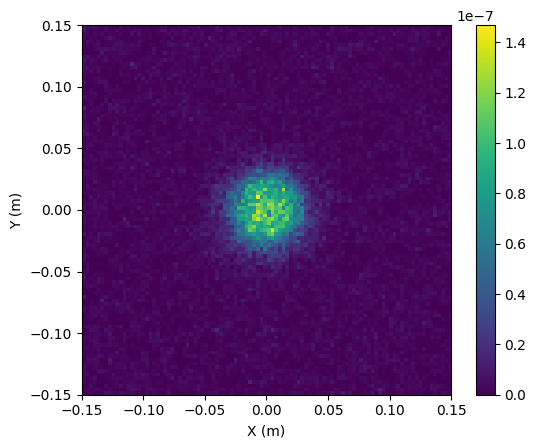

In [51]:
xmin = dose_histo.xedges.min()
xmax = dose_histo.xedges.max()

ymin = dose_histo.yedges.min()
ymax = dose_histo.yedges.max()

zmin = dose_histo.zedges.min()
zmax = dose_histo.zedges.max()

plt.imshow(dose_histo.contents[:,:,0],extent=[xmin,xmax,ymin,ymax]) #can later define more z bins to get different depths dont need to rereun.
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

[-148.5 -145.5 -142.5 -139.5 -136.5 -133.5 -130.5 -127.5 -124.5 -121.5
 -118.5 -115.5 -112.5 -109.5 -106.5 -103.5 -100.5  -97.5  -94.5  -91.5
  -88.5  -85.5  -82.5  -79.5  -76.5  -73.5  -70.5  -67.5  -64.5  -61.5
  -58.5  -55.5  -52.5  -49.5  -46.5  -43.5  -40.5  -37.5  -34.5  -31.5
  -28.5  -25.5  -22.5  -19.5  -16.5  -13.5  -10.5   -7.5   -4.5   -1.5
    1.5    4.5    7.5   10.5   13.5   16.5   19.5   22.5   25.5   28.5
   31.5   34.5   37.5   40.5   43.5   46.5   49.5   52.5   55.5   58.5
   61.5   64.5   67.5   70.5   73.5   76.5   79.5   82.5   85.5   88.5
   91.5   94.5   97.5  100.5  103.5  106.5  109.5  112.5  115.5  118.5
  121.5  124.5  127.5  130.5  133.5  136.5  139.5  142.5  145.5  148.5]


/Users/sabrinawang/Desktop/DPhil_Project/uniformity_fit.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


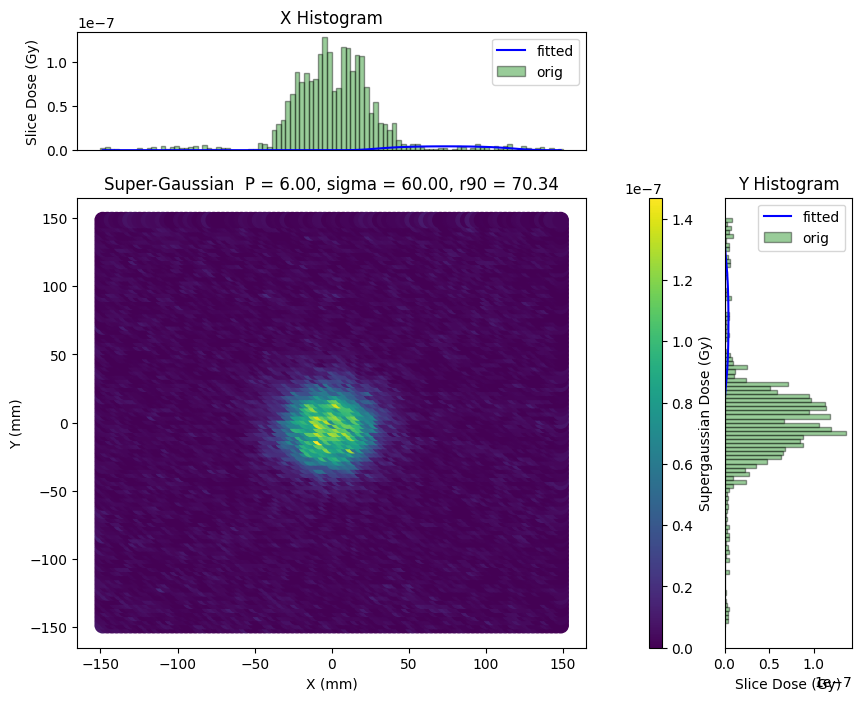

In [52]:
from uniformity_fit import *

x,y = dose_histo.xcentres*1000,dose_histo.ycentres*1000
doseMap = dose_histo.contents[:,:,0]
x_center = (x.max() + x.min()) / 2  # Find the midpoint of x
y_center = (y.max() + y.min()) / 2 
x = x - x_center
y = y - y_center
x, y = np.meshgrid(x, y)

p0=[0.2, np.max(x)//2, np.max(y)//2, 60, 60, 6]
#curvefit 2d histogram to supergaussian
# Perform the optimization
result = minimize(MSE, p0, args=(x, y, doseMap), method='L-BFGS-B')
fit_params = result.x

# Calculate the fitted super-Gaussian
fitted_map = supergaussian(x, y, *fit_params)
sig, P = fit_params[3], fit_params[5]
r_90 = r90(sig,P)
plotDoseMap(x, y, doseMap,fitted_map,P,sig,r_90, dose_depth, "bdsim_dose")
